In [1]:
from sage.all import Graph, graphs


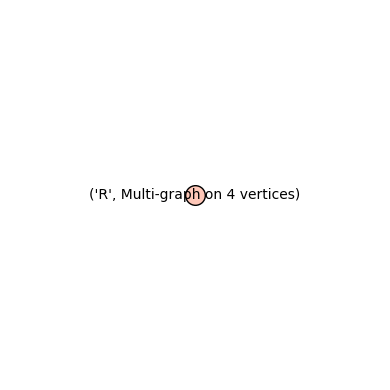

In [2]:
G = graphs.CompleteGraph(4)
spqr = G.spqr_tree()
spqr.plot()


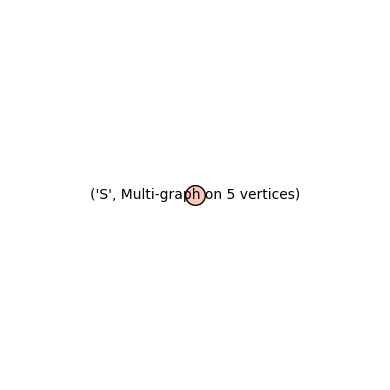

In [3]:
H = graphs.CycleGraph(5)
spqr = H.spqr_tree()
spqr.plot()


Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges: [(1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (4, 6)]


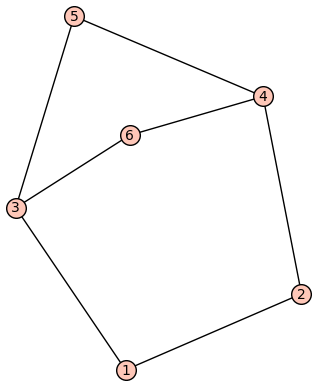

SPQR tree successfully computed.
SPQR tree has 4 nodes and 3 edges
Node 0: type=S, skeleton edges=[(3, 4), (3, 6), (4, 6)]
Node 1: type=S, skeleton edges=[(3, 4), (3, 5), (4, 5)]
Node 2: type=P, skeleton edges=[(3, 4), (3, 4), (3, 4)]
Node 3: type=S, skeleton edges=[(1, 2), (1, 3), (2, 4), (3, 4)]
SPQR tree edge: (('P', Multi-graph on 2 vertices), ('S', Multi-graph on 3 vertices))
SPQR tree edge: (('P', Multi-graph on 2 vertices), ('S', Multi-graph on 3 vertices))
SPQR tree edge: (('P', Multi-graph on 2 vertices), ('S', Multi-graph on 4 vertices))


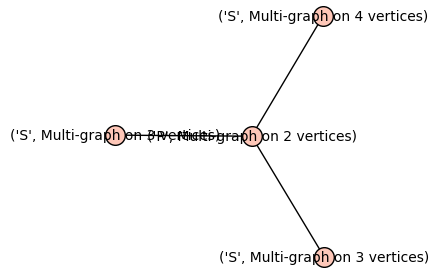

In [14]:
# Define the graph
edges = [(1,2), (1,3), (3,5), (3,6), (5,4), (6,4), (4,2)]
K = Graph(edges)

print("Original graph vertices:", K.vertices())
print("Original graph edges:", K.edges(labels=False))
K.show()

try:
    spqr = K.spqr_tree()
    print("SPQR tree successfully computed.")
    print(f"SPQR tree has {spqr.num_verts()} nodes and {spqr.num_edges()} edges")

    # Extract vertices without forcing comparison
    vertices = list(spqr.vertex_iterator())
    for i, v in enumerate(vertices):
        node_type, skeleton = v
        print(f"Node {i}: type={node_type}, skeleton edges={skeleton.edges(labels=False)}")

    # Extract edges safely
    edges = list(spqr.edge_iterator(labels=False))
    for e in edges:
        print("SPQR tree edge:", e)

    # Visualize
    spqr.show()
except Exception as e:
    print("SPQR decomposition failed at inspection:", e)


Original graph vertices: [1, 2, 3, 4, 5, 6]
Original graph edges (with labels): [(1, 2, '__ROOT_EDGE__'), (1, 3, None), (2, 4, None), (3, 5, None), (3, 6, None), (4, 5, None), (4, 6, None)]


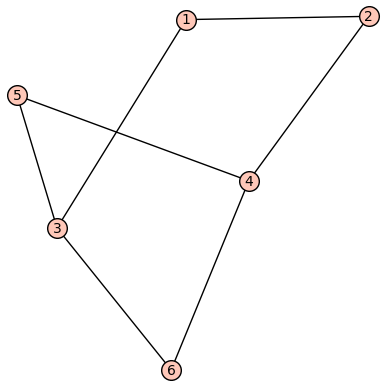

SPQR tree successfully computed.
SPQR tree has 4 nodes and 3 edges
Rooting SPQR tree at node containing edge (1, 2) (type = S ).

Nodes in BFS order from the chosen root:
[0] type=S, skeleton edges (sample)=[(1, 2, '__ROOT_EDGE__'), (1, 3, None), (2, 4, None), (3, 4, 'newVEdge2')]
[1] type=P, skeleton edges (sample)=[(3, 4, 'newVEdge0'), (3, 4, 'newVEdge1'), (3, 4, 'newVEdge2')]
[2] type=S, skeleton edges (sample)=[(3, 4, 'newVEdge0'), (3, 6, None), (4, 6, None)]
[3] type=S, skeleton edges (sample)=[(3, 4, 'newVEdge1'), (3, 5, None), (4, 5, None)]

Directed edges (parent -> child) in rooted SPQR tree:
  2 -> 0
  2 -> 1
  3 -> 2


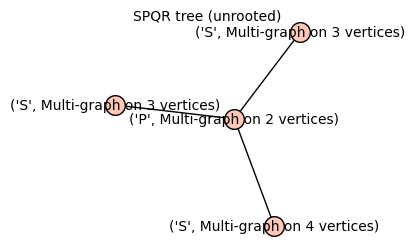

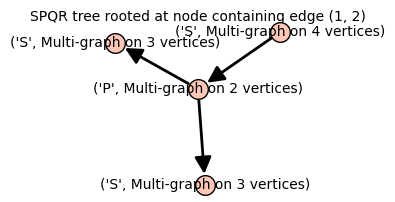

In [23]:
# SageMath code

# --- 1) Build the input graph and TAG the root edge (1,2) ---
raw_edges = [(1,2), (1,3), (3,5), (3,6), (5,4), (6,4), (4,2)]
ROOT_UV = (1, 2)
ROOT_TAG = "__ROOT_EDGE__"

# Rebuild edges with a unique label on (1,2) so we can find it later
labeled_edges = []
for (u, v) in raw_edges:
    if {u, v} == set(ROOT_UV):
        labeled_edges.append((u, v, ROOT_TAG))
    else:
        labeled_edges.append((u, v, None))

K = Graph(labeled_edges)  # multiedges not needed here; labels preserved

print("Original graph vertices:", K.vertices())
print("Original graph edges (with labels):", K.edges(labels=True))
K.show()

# --- 2) SPQR decomposition ---
from sage.graphs.connectivity import spqr_tree as spqr_tree_fn
T = spqr_tree_fn(K)
print("SPQR tree successfully computed.")
print(f"SPQR tree has {T.num_verts()} nodes and {T.num_edges()} edges")

nodes = list(T.vertex_iterator())

# --- 3) Find the node whose skeleton contains the ROOT_TAG real edge ---
def skeleton_contains_root_edge(skel):
    for (a, b, lab) in skel.edges(labels=True):
        # Match by label first (robust across integer/Integer vertex types)
        if lab == ROOT_TAG:
            return True
    return False

root_node = None
for v in nodes:
    if skeleton_contains_root_edge(v[1]):
        root_node = v
        break

if root_node is None:
    raise ValueError("Could not locate the tagged root edge in any SPQR skeleton. "
                     "Ensure the input graph uses the labeled edge list above.")

print("Rooting SPQR tree at node containing edge", ROOT_UV, "(type =", root_node[0], ").")

# --- 4) Orient the (unrooted) SPQR tree away from the chosen root for traversal ---
from collections import deque

adj = {v: [] for v in nodes}
for (x, y, _) in T.edge_iterator(labels=True):
    adj[x].append(y)
    adj[y].append(x)

parent = {root_node: None}
order = []
Q = deque([root_node])
while Q:
    u = Q.popleft()
    order.append(u)
    for w in adj[u]:
        if w not in parent:
            parent[w] = u
            Q.append(w)

Td = DiGraph()
for v in nodes:
    Td.add_vertex(v)
for v, p in parent.items():
    if p is not None:
        Td.add_edge(p, v)

# --- 5) Summaries ---
def short_edges(skel, limit=6):
    es = list(skel.edges(labels=True))
    return es if len(es) <= limit else es[:limit] + [f"...(+{len(es)-limit} more)"]

print("\nNodes in BFS order from the chosen root:")
for i, v in enumerate(order):
    t, sk = v
    print(f"[{i}] type={t}, skeleton edges (sample)={short_edges(sk)}")

print("\nDirected edges (parent -> child) in rooted SPQR tree:")
idx = {v:i for i, v in enumerate(nodes)}
for (u, v) in Td.edge_iterator(labels=False):
    print(f"  {idx[u]} -> {idx[v]}")

# --- 6) Visualize (optional) ---
T.show(title="SPQR tree (unrooted)")
Td.show(title=f"SPQR tree rooted at node containing edge {ROOT_UV}")
